<a href="https://colab.research.google.com/github/R-802/LING-226-Assignments/blob/main/Assignment_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LING226 2023 T3 Assignment One
- Shemaiah Rangitaawa `300601546`
- Attempting Challenge

**Note:** Given the computationally demanding tasks in some parts of this notebook, operating in a GPU-based runtime environment is beneficial. However, it's not mandatory, as I have tried to include as much detail as possible in my discussions. This notebook also uses certain features exclusive to Google Colab, in particular its form functionality. However, this too is not required.

In [117]:
import string
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)

def clean_text(text, stop_words=None, remove_punctuation=True, to_lowercase=True):
    if to_lowercase:
        text = text.lower()

    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    words = word_tokenize(text)

    # Filter out stop words
    filtered_words = [word for word in words if word not in stop_words]

    # Rejoin the words into a processed text
    return ' '.join(filtered_words)

## **Text Preprocessing Using Term Frequency Filtering**

In [118]:
def preprocess_tf(text, stop_words, min_freq=1, max_freq=float('inf')):
    text = clean_text(text, stop_words)
    words = word_tokenize(text)
    frequency = Counter(words)
    filtered_words = [word for word in words if min_freq <= frequency[word] <= max_freq]
    return ' '.join(filtered_words)

## **Text Metrics**

In [110]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from collections import Counter

nltk.download('punkt', quiet=True)

def lexical_diversity(words):
    return len(set(words)) / len(words) if words else 0

def text_metrics(text):
    # Tokenization and basic processing
    words = word_tokenize(text.lower())
    overall_lexical_diversity = lexical_diversity(words)
    num_words = len(words)
    unique_words = len(set(words))

    # Sentence tokenization
    sentences = sent_tokenize(text)

    # Lexical diversity per sentence
    sentence_diversities = []
    for sentence in sentences:
        words_in_sentence = word_tokenize(sentence.lower())
        sentence_diversity = lexical_diversity(words_in_sentence)
        sentence_diversities.append(sentence_diversity)

    # Average lexical diversity of sentences
    avg_sentence_lexical_diversity = sum(sentence_diversities) / len(sentence_diversities) if sentence_diversities else 0

    # Top ten most frequent words
    top_ten_words = Counter(words).most_common(10)

    num_sentences = len(sentences)

    # Frequency Distribution
    freq_distribution = FreqDist(words)

    return {
        'num_words': num_words,
        'lexical_diversity': overall_lexical_diversity,
        'avg_sentence_lexical_diversity': avg_sentence_lexical_diversity,
        'top_ten_words': top_ten_words,
        'num_sentences': num_sentences,
        'frequency_distribution': freq_distribution
    }

###**Formatting Function for Text Metrics**

In [143]:
def format_metrics(titles, metrics_list, is_preprocessed=True):
    for title, metrics in zip(titles, metrics_list):
        if metrics['top_ten_words']:
            formatted_top_words = ', '.join([f"'{word}' ({freq})" for word, freq in metrics['top_ten_words']])
            highest_word, highest_freq = metrics['top_ten_words'][0]  # Extracting the highest frequency word and its frequency
        else:
            formatted_top_words = "None"
            highest_word, highest_freq = ("N/A", 0)

        # Formatting the diversities as percentages
        overall_diversity_percentage = metrics['lexical_diversity'] * 100
        avg_sentence_diversity_percentage = metrics['avg_sentence_lexical_diversity'] * 100

        print(f"--------- Text Metrics for {title} ---------")
        print(f"Total Words: {metrics['num_words']}")
        if not is_preprocessed:
            print(f"Total Sentences: {metrics['num_sentences']}")
            print(f"Average Lexical Diversity of Sentences: {avg_sentence_diversity_percentage:.2f}%")
        print(f"Overall Lexical Diversity: {overall_diversity_percentage:.2f}%")
        print(f"Top Ten Most Frequent Words: {formatted_top_words}")
        print(f"Highest Frequency Word: '{highest_word}' (Frequency: {highest_freq})")
        """
        print("Frequency Distribution:")
        for word, frequency in metrics['frequency_distribution'].items():
            print(f"  '{word}': {frequency}")
        """
        print()

# **Experimentation And Disscussion**

**Notes:** I have chosen to use the NLTK's stopword list for preprocessing.

In [ ]:
# @title ##**Importing and Reading `TP001.txt`, `TP002.txt` from URL and `austen-emma.txt` from NLTK corpora** {display-mode: "form"}
# @markdown It's only required to run this cell once. This cell is dedicated to importing `TP001.txt`, `TP002.txt`, and `austen-emma.txt` for processing. Spellcheck is performed on `TP001.txt`, `TP002.txt` to ensure consistency.
!wget 'https://raw.githubusercontent.com/scskalicky/LING-226-vuw/main/the-current/tp001.txt'
!wget 'https://raw.githubusercontent.com/scskalicky/LING-226-vuw/main/the-current/tp002.txt'
!pip install symspellpy

import pkg_resources
from nltk.corpus import gutenberg
from symspellpy import SymSpell, Verbosity

nltk.download('gutenberg', quiet=True)

def read_comments_from_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        return " ".join(line.split('\t')[1].strip() for line in file if '\t' in line)

def spellcheck(text):
    # Initialize SymSpell
    symspell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
    symspell.load_dictionary(dictionary_path, term_index=0, count_index=1)

    # Tokenize the input text
    words = text.split()
    corrected_text = []
    for word in words:
        # Get the best suggestion
        suggestions = symspell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)

        # Use the most likely suggestion, or the original word if no suggestion found
        if suggestions:
            corrected_word = suggestions[0].term
        else:
            corrected_word = word
        corrected_text.append(corrected_word)

    # Join the corrected words back into a string
    return ' '.join(corrected_text)

# Read and process the texts
tp001 = read_comments_from_file('tp001.txt')
tp002 = read_comments_from_file('tp002.txt')

# Using Emma by Jane Austen 1816
emma_text = gutenberg.raw('austen-emma.txt')

# Fix spelling
tp001_text = spellcheck(tp001)
tp002_text = spellcheck(tp002)

## **Initializing NLTK Stopwords**
I have also added some random words and characters that appeared during analysis and contributed little to the overall contents of the texts.

In [151]:
import nltk
from nltk.corpus import stopwords

# Using stopwords from NLTK
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Additional words to the stopwords set
additional_stopwords = {'ä', 'å', 'pä',
                        'n', 's', 'r', 'tä', 'wä', 'thä', 'bä', 'ahhhhhhhhhhhh',
                        'hxbdjs', 'aga', 've', 'fhdvb', 'vvvvv'}
stop_words.update(additional_stopwords)

In [99]:
# @title ##**Graphing Function Definition** {display-mode: "form"}
# @markdown Although `text_metrics` already returns a list of the top 10 words, for flexiblity, I instead decided to use the frequency distribution returned from `text_metrics` and extract the `n` most common words.

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from nltk.probability import FreqDist

def plot_word_frequency(metrics_list, n, titles, canvas_title):
    num_plots = len(metrics_list)
    fig = make_subplots(rows=num_plots, cols=1, subplot_titles=titles)
    for i, metrics in enumerate(metrics_list, start=1):
        # Extract frequency distribution and get the top n words
        freq_dist = metrics['frequency_distribution']
        word_freq = freq_dist.most_common(n)

        # Separate the words and their frequencies
        words = [wf[0] for wf in word_freq]
        frequencies = [wf[1] for wf in word_freq]

        # Create a colorscale with the same number of colors as the number of words
        colorscale = px.colors.sequential.Emrld_r[:len(words)]

        # Add the plot to the subplot
        fig.add_trace(
            go.Bar(
                x=frequencies,
                y=words,
                orientation='h',
                name=titles[i-1],
                marker=dict(
                    color=frequencies,
                    colorscale=colorscale
                )
            ),
            row=i, col=1
        )

    fig.update_layout(
        title=canvas_title,
        height=300 * num_plots,  # Adjust height based on number of plots
        showlegend=False
    )

    # Reverse the y-axis to show the highest frequency on top for each subplot
    for i in range(num_plots):
        fig.update_yaxes(autorange="reversed", row=i + 1, col=1)

    # Show the plot
    fig.show()

## **Analysis and Overview of Key Metrics from Sample Texts Before and After Pre-processing**




In [152]:
# @title Raw Text Metrics {display-mode: "form"}
# @markdown

# Get text metrics for raw unprocessed text
emma_metrics = text_metrics(emma_text)
tp001_metrics = text_metrics(tp001_text)
tp002_metrics = text_metrics(tp002_text)

# Prepare titles and metrics for the formatting
titles = ["Emma - Raw Text", "Ban Petrol Cars by 2030 (TP001) - Raw Text", "Sustainable Fish Sales (TP002) - Raw Text"]
metrics_list = [emma_metrics, tp001_metrics, tp002_metrics]
format_metrics(titles, metrics_list, is_preprocessed=False)

--------- Text Metrics for Emma - Raw Text ---------
Total Words: 191781
Total Sentences: 7493
Average Lexical Diversity of Sentences: 90.32%
Overall Lexical Diversity: 4.14%
Top Ten Most Frequent Words: ',' (12016), '.' (6351), 'the' (5201), 'to' (5181), 'and' (4877), 'of' (4284), 'i' (3177), 'a' (3124), '--' (3100), 'it' (2503)
Highest Frequency Word: ',' (Frequency: 12016)

--------- Text Metrics for Ban Petrol Cars by 2030 (TP001) - Raw Text ---------
Total Words: 39665
Total Sentences: 101
Average Lexical Diversity of Sentences: 55.22%
Overall Lexical Diversity: 9.48%
Top Ten Most Frequent Words: 'the' (1572), 'to' (1503), 'a' (1119), 'and' (979), 'we' (896), 'of' (760), 'it' (735), 'be' (729), 'is' (694), 'for' (634)
Highest Frequency Word: 'the' (Frequency: 1572)

--------- Text Metrics for Sustainable Fish Sales (TP002) - Raw Text ---------
Total Words: 149382
Total Sentences: 533
Average Lexical Diversity of Sentences: 62.66%
Overall Lexical Diversity: 5.53%
Top Ten Most Frequ

In [ ]:
# Plot the top 10 words from each text
plot_word_frequency(metrics_list, 10, titles, "Top 10 Words From Raw Texts")

###**Analysis of Raw Unprocessed Texts**
**Emma by Jane Austen**

The metrics confirm the characteristics of a classic novel: extensive length, a high number of sentences, and a low overall lexical diversity, which is typical for long narratives. The high average lexical diversity per sentence reflects Jane Austen's varied and rich use of language within individual sentences.

**TP001 (Petrol cars should be banned by 2030)**

The shorter length and significantly higher overall lexical diversity compared to "Emma" suggest diverse viewpoints and varied vocabulary used by different respondents. The lower average lexical diversity per sentence could be due to more straightforward, argumentative sentence structures typical in responses or opinions. The frequent use of words like 'we', 'be', and 'for' indicates a focus on collective action and future-oriented propositions.

**TP002 (Supermarkets should only sell sustainably caught fish)**

This text is longer than TP001, possibly indicating more detailed responses or larger numbers of contributors. The presence of 'fish' among the most frequent words directly reflects the topic. The overall and average lexical diversities suggest a balance between varied vocabulary and straightforward sentence structures, possibly due to the mix of technical terms and general argumentative language in the responses.

Overall, the raw text metrics show that the three texts have different characteristics. Emma has the highest number of words and sentences, while TP001 has the lowest. TP001 also has the highest lexical diversity, while Emma has the lowest. The most frequent word in all three texts is 'the', which is expected in raw texts.

**Top 10 Words from Raw Texts**

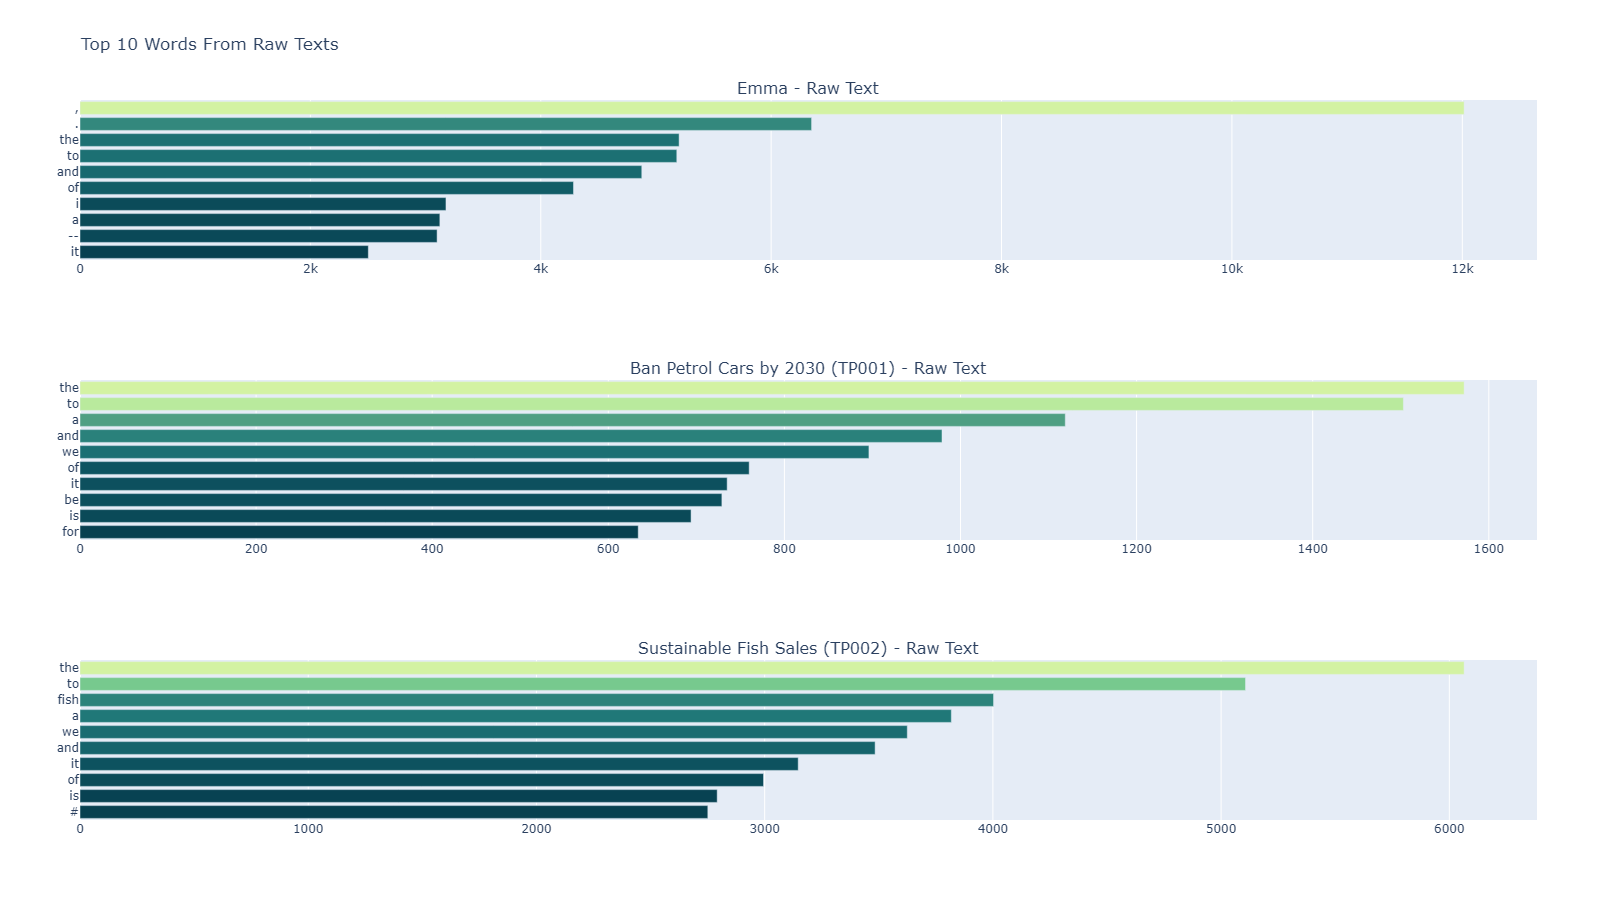

For "Emma," the graph shows a high frequency of the most common English words like 'the', 'to', 'and', 'of', and 'a'. This is typical for unprocessed English-language texts, as these words are often the glue that holds sentences together. The substantial frequency of these words suggests a rich narrative style, which is expected in a classic novel that utilizes complex sentence structures and descriptive passages.

In "TP001," the frequencies of the top words are noticeably lower than in "Emma," yet 'the' remains the most common. The presence of words like 'we', 'be', 'is', and 'for' indicate a more conversational or argumentative text, reflecting discourse on a topic where personal opinions, suggestions, and reasoning are prominent.

"TP002" shows a unique inclusion of the word 'fish', which stands out against the backdrop of otherwise common English words. The word 'fish' having a high frequency immediately suggests the subject matter, which is the sustainablity of fish sales.

The graph also illustrates the difference in vocabulary richness and text length among the three texts. "Emma" appears to have a much higher word count, reflective of its status as a novel, whereas "TP001" and "TP002" have fewer words, which may point to them being shorter texts like essays or articles.

Overall, the unprocessed word frequencies provide a foundational understanding of each text's content and style. The frequent appearance of common words is expected, but the presence of specific terms like 'fish' in "TP002" offers a hint of the text's thematic focus. This baseline data plays a critical role in subsequent phases of text analysis and proved particularly valuable in the following section, which involved experimentation with and determination of word frequency thresholds for removal.

---

In [149]:
# @title Pre-processing {display-mode: "form"}
# @markdown These sliders were designed to help select the ideal frequency range for text removal during preprocessing. The "upper bound" (ub) setting is used for excluding overly common words that aren't stopwords from the analysis. When a word's frequency exceeds this upper limit, it is removed from the text.
# @markdown
# @markdown The "lower bound" (lb) setting targets infrequently used words. Words that appear less often than this lower threshold are considered too rare to be relevant and are thus excluded. These might include typographical errors, extremely niche terms, or words that are highly specific to the text's context.

# Upper and lower bounds for word removal
emma_ub = 4685 # @param {type:"slider", min:1, max:5000, step:5}
emma_lb = 125 # @param {type:"slider", min:1, max:5000, step:5}
tp001_ub = 2950 # @param {type:"slider", min:1, max:5000, step:5}
tp001_lb = 375 # @param {type:"slider", min:1, max:5000, step:5}
tp002_ub = 3615 # @param {type:"slider", min:1, max:5000, step:5}
tp002_lb = 300 # @param {type:"slider", min:1, max:5000, step:5}

# Preprocess the texts
tf_emma = preprocess_tf(emma_text, stop_words, 100, 5000)
tf_tp001 = preprocess_tf(tp001_text, stop_words, 10, 800)
tf_tp002 = preprocess_tf(tp002_text, stop_words, 10, 2000)

# Get text metrics
tf_emma_metrics = text_metrics(tf_emma)
tf_tp001_metrics = text_metrics(tf_tp001)
tf_tp002_metrics = text_metrics(tf_tp002)

# Prepare titles and metrics for printing
tf_titles = ["Emma - Pre-processed Text", "Ban Petrol Cars by 2030 (TP001) - Pre-processed Text", "Sustainable Fish Sales (TP002) - Pre-processed Text"]
tf_metrics_list = [tf_emma_metrics, tf_tp001_metrics, tf_tp002_metrics]
format_metrics(tf_titles, tf_metrics_list)

--------- Text Metrics for Emma - Pre-processed Text ---------
Total Words: 22064
Overall Lexical Diversity: 0.46%
Top Ten Most Frequent Words: 'could' (830), 'would' (817), 'emma' (751), 'must' (567), 'much' (474), 'said' (474), 'one' (428), 'every' (427), 'harriet' (390), 'thing' (385)
Highest Frequency Word: 'could' (Frequency: 830)

--------- Text Metrics for Ban Petrol Cars by 2030 (TP001) - Pre-processed Text ---------
Total Words: 13603
Overall Lexical Diversity: 2.46%
Top Ten Most Frequent Words: 'cars' (562), 'petrol' (394), 'environment' (334), 'need' (331), 'think' (283), 'electric' (264), 'change' (227), 'better' (213), 'planet' (208), 'good' (206)
Highest Frequency Word: 'cars' (Frequency: 562)

--------- Text Metrics for Sustainable Fish Sales (TP002) - Pre-processed Text ---------
Total Words: 52923
Overall Lexical Diversity: 1.64%
Top Ten Most Frequent Words: 'think' (1251), 'need' (1178), 'sustainable' (953), 'future' (899), 'would' (832), 'good' (789), 'people' (717),

In [ ]:
# Plot the top 10 words from each text
plot_word_frequency(tf_metrics_list, 10, tf_titles, "Top 10 Words From Pre-processed Texts")

###**Analysis of Results and Effects of Pre-processing the Texts**
**Emma**

The preprocessing of Jane Austen's "Emma" often led to a noticeable decrease in both the total word count and the overall lexical diversity. This reduction in lexical diversity indicates that the text is now predominantly composed of a limited range of words. A striking feature of this condensed version is the repeated appearance of character names such as 'Emma' and 'Harriet.' Their prominence reveals that the narrative is centered around these key figures.

Additionally, the frequent usage of words like 'could', 'would', and 'must' mirrors the speculative and reflective tone of the novel. These words suggest a focus on the characters' internal deliberations and the hypothetical scenarios they consider, especially in their social interactions and personal musings. However, this narrowed lexical range also implies that the preprocessing may have inadvertently stripped away much of Austen's linguistic richness. As a result, some of the subtleties and less common words that add depth and nuance to her writing might have been lost. This loss potentially affects the intricate layers and the full essence of the original text, which is characterized by its rich and varied vocabulary.

**TP001**

The preprocessed version of TP001, focusing on the topic of banning petrol cars by 2030, shows a notably higher lexical diversity (2.46%) compared to "Emma". This higher diversity could be attributed to the inclusion of more specialized vocabulary pertinent to environmental issues and automobile technology. The text is dominated by words like 'cars', 'petrol', 'environment', and 'electric', clearly reflecting its environmental theme. The presence of words such as 'need', 'think', 'change', 'better', and 'good' points towards a text that is not just descriptive but also persuasive, likely advocating for environmental action or policy change. These words suggest an opinionated nature of the text, possibly comprising arguments, suggestions, or reflections on the environmental impact of petrol cars and the potential benefits of electric vehicles. The lexical choices paint a picture of a discourse deeply engaged in environmental concerns, echoing contemporary debates on sustainable practices and technological shifts in transportation.

**TP002**

The preprocessing of TP002, center around the topic of selling only sustainably caught fish, results in a text with a relatively high word count of 52,923 and a lexical diversity of 1.64%. The most frequent words, such as 'think', 'need', 'sustainable', 'future', 'would', and 'environment', highlight the text’s focus on sustainability, particularly in the context of future planning and environmental conservation. The word 'think' appears 1,251 times, suggesting a reflective or opinion-based nature of the text, likely containing personal viewpoints or collective sentiments about sustainability. The diverse use of terms like 'good', 'people', 'done', 'better', and 'environment' indicates a comprehensive discussion encompassing various aspects of sustainability, from individual responsibilities to broader societal impacts. This lexical analysis points to a text rich in ideas and perspectives on sustainability, possibly including debates, suggestions, and reflections on sustainable practices in the context of environmental preservation and future generations' well-being.

**Top 10 Words After Pre-processing**

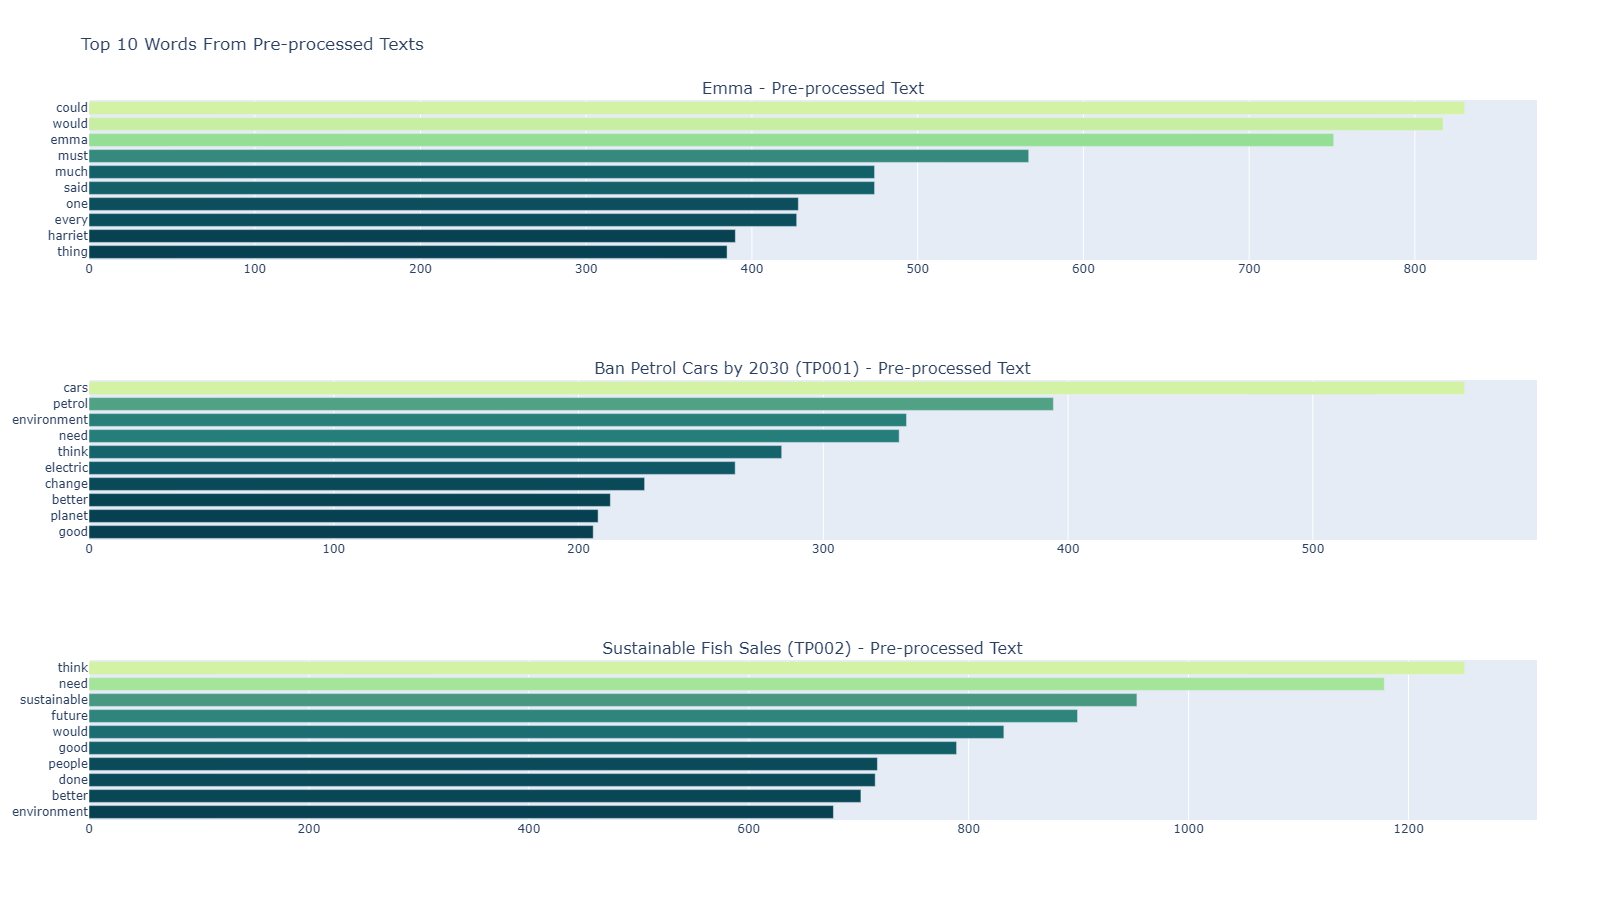

Graphing the top 10 most frequent words from the pre-processed texts of "Emma," "TP001," and "TP002." highlights the prevalence of specific words in each text, indicating key thematic focuses. "Emma" shows character names and modal verbs like 'could' and 'would' as most frequent, underscoring character-centric narrative and introspective content. "TP001" centers around 'cars' and environmental terms, reflecting a discourse on automotive impact and environmental considerations. "TP002" features 'think' and 'sustainable' among the top, suggesting a reflective discussion on sustainability. The word frequencies across the texts vary, with "TP002" showing the highest frequency counts, indicating a broader discussion or larger dataset.

# **Further Experimentation (Challenge)**
The following experimentation section includes:
- An analysis and overview of metrics from both sample texts.  
- Visualization of the top ten words before and after both processing methods.
- Analysis of Emma's overall lexical diversity before and after processing.

## **Text Preprocessing Using Term Frequency - Inverse Document Frequency (TF-IDF) Filtering**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def preprocess_tf_idf(texts, stop_words, idf_percentile_lower=10, idf_percentile_upper=90):
    """
    Preprocess texts by calculating TF-IDF and filtering words based on TF-IDF percentile thresholds.

    :param texts: List of input texts to be preprocessed.
    :param stop_words: Words to be removed from the text.
    :param idf_percentile_lower: Lower percentile threshold for TF-IDF scores.
    :param idf_percentile_upper: Upper percentile threshold for TF-IDF scores.
    :return: List of preprocessed texts.
    """
    # Tokenize and clean each document
    clean_docs = [clean_text(text, stop_words) for text in texts]  # clean_text should return a string

    # Create a TF-IDF Vectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(clean_docs)

    # Get feature names and TF-IDF score
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

    # Calculate percentile thresholds
    lower_threshold = np.percentile(tfidf_scores, idf_percentile_lower)
    upper_threshold = np.percentile(tfidf_scores, idf_percentile_upper)

    # Filter words based on TF-IDF scores
    filtered_words = [feature_names[i] for i in range(len(feature_names))
                      if lower_threshold <= tfidf_scores[i] <= upper_threshold]

    # Reconstruct the documents using filtered words
    preprocessed_texts = []
    for doc in clean_docs:
        words = doc.split()
        preprocessed_texts.append(" ".join([word for word in words if word in filtered_words]))

    return preprocessed_texts

## **Text Preprocessing Using Context-based Filtering**
The core idea behind this filtering approach is ensuring that text is processed in a way that keeps the most important information intact while getting rid of any distracting or unimportant elements. The goal is to maintain what matters most in a text and remove anything that doesn't contribute directly to the primary topic or objective of the text.

This approach attemts to consider the relationships and meanings associated with those terms in their specific context by using sentence embeddings to measure similarity with keyword or keyphrase embeddings as opposed to relying on the frequency of terms. This preserves the nuanced and semantic information that can be lost in a simple term frequency analysis.

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# Setting up the device for GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)

# Checking if CUDA is available and getting the GPU device name
cuda_available = torch.cuda.is_available()
gpu_name = torch.cuda.get_device_name(0) if cuda_available else "No CUDA Device Available"

cuda_available, gpu_name

In [ ]:
# Function to create BERT embeddings
def create_embeddings(text, model=model, tokenizer=tokenizer, device='cuda'):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512, add_special_tokens=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.last_hidden_state
    text_embedding = hidden_states.mean(dim=1).squeeze(0)

    return text_embedding

In [ ]:
from nltk.tokenize import sent_tokenize
import torch.nn.functional as F

# Main function to preprocess text
def preprocess(text, keyword_embeddings, stop_words, threshold=0.5):
    sentences = sent_tokenize(text)
    filtered_sentences = []

    for sentence in sentences:
        sentence_embedding = create_embeddings(sentence)
        similarities = [F.cosine_similarity(
                            sentence_embedding.unsqueeze(0),
                            keyword_emb.unsqueeze(0), dim=1)
                            for keyword_emb in keyword_embeddings]

        # Check if any similarity is above the threshold
        similarity_above_threshold = any(similarity > threshold for similarity in similarities)

        # Retain the sentence if similarity is above the threshold
        if similarity_above_threshold:
            filtered_sentences.append(sentence)

    processed_text = ' '.join(filtered_sentences)

    # Clean text after removing words
    return clean_text(processed_text, stop_words)

### **Keyword Extraction**

Using [KeyBERT](https://github.com/MaartenGr/KeyBERT) for keyword extraction.

In [ ]:
!pip install keybert
!pip install sentence_transformers

In [ ]:
from keybert import KeyBERT
import torch

# Initialize KeyBERT model
kw_model = KeyBERT()

def extract_keywords(text, num_keywords=5):
    # Extract keywords from the text
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(3, 3), stop_words='english', use_maxsum=True, nr_candidates=20, top_n=5)

    # Extract just the keywords (first element of each tuple)
    extracted_keywords = [keyword[0] for keyword in keywords]

    # Tokenize and encode extracted keywords in a batch
    key_word_tokens = tokenizer(extracted_keywords, padding=True, return_tensors="pt").to(device)

    with torch.no_grad():
        key_word_outputs = model(**key_word_tokens)
    key_word_embeddings = key_word_outputs.last_hidden_state.mean(dim=1)

    return {
        'key_word_embeddings': key_word_embeddings,
        'keywords': extracted_keywords
    }

### **Analyzing Texts Processed with Context-Based Filtering**
This section is computationally and resource intensive, it can also take a while to run, typically under 4 minutes on a Tesla T4 in the colab runtime environment. It can be skipped, as I have dissused the results in other parts of this notebook.

In [ ]:
# Extracting keywords for preprocessing
num_tp001_keywords = 7
tp001_keywords = extract_keywords(tp001_text, num_tp001_keywords)
print(tp001_keywords['keywords'])

num_tp002_keywords = 8
tp002_keywords = extract_keywords(tp002_text, num_tp002_keywords)
print(tp002_keywords['keywords'])

num_emma_keywords = 10
emma_keywords = extract_keywords(emma_text, num_emma_keywords)
print(emma_keywords['keywords'])

emma_keyword_embeddings = emma_keywords['key_word_embeddings']
tp001_keyword_embeddings = tp001_keywords['key_word_embeddings']
tp002_keyword_embeddings = tp002_keywords['key_word_embeddings']

['environment banning', 'revolutionary change', 'bikes instead', 'begin petrol', 'technologies support', 'diseases future', 'evaluate priorities', 'totally agree', 'pray lao', 'economical torque', 'cd minimum', 'exist charging', 'change saving', 'cell functional', 'dairy intake', 'number babyboomers', 'fhdvb vvvvv']
['fishing sustainability', 'force prices', 'agree ve', 'pie step', 'protecting keys', 'carbs eat', 'average kiwi', 'inortaibt environment', 'setters rest', 'discriminates people', 'mercury levels', 'create medicine', 'qms help', 'brush options', 'confirmed happens']
['emma circumstances', '1816 volume', 'governess mean', 'marriage poorer', 'sent mrs', 'father uneasy', 'woodhouses settled', 'bilious means', 'clemency hard', 'hartfield agreeable', 'write book', 'taste valued', 'connexion dependent', 'difference randalls', 'increasing coldness', 'continue error', 'rendered protecting', 'device flatter', 'point smallest', 'venture salary']


In [ ]:
# Preprocess TP001 text
preprocessed_tp001 = preprocess(tp001_text, tp001_keyword_embeddings, stop_words)
preprocessed_tp001_metrics = text_metrics(preprocessed_tp001)
format_metrics(["TP001 - Context-based Preprocessing"], [preprocessed_tp001_metrics])

# Preprocess TP002 text
preprocessed_tp002 = preprocess(tp002_text, tp002_keyword_embeddings, stop_words)
preprocessed_tp002_metrics = text_metrics(preprocessed_tp002)
format_metrics(["TP002 - Context-based Preprocessing"], [preprocessed_tp002_metrics])

# Preprocess Emma text
preprocessed_emma = preprocess(emma_text, emma_keyword_embeddings, stop_words)
preprocessed_emma_metrics = text_metrics(preprocessed_emma)
format_metrics(["Emma - Context-based Preprocessing"], [preprocessed_emma_metrics])

--------- Text Metrics for TP001 - Preprocessed Text ---------
Total Words: 6788
Total Sentences: 1
Overall Lexical Diversity: 30.17%
Average Lexical Diversity of Sentences: 30.17%
Top Ten Most Frequent Words: cars, petrol, think, environment, need, people, electric, change, better, would
Highest Frequency Word: 'cars' (Frequency: 216)

--------- Text Metrics for TP002 - Preprocessed Text ---------
Total Words: 2411
Total Sentences: 1
Overall Lexical Diversity: 45.33%
Average Lexical Diversity of Sentences: 45.33%
Top Ten Most Frequent Words: fish, need, think, eat, people, sustainable, future, better, would, environment
Highest Frequency Word: 'fish' (Frequency: 141)

--------- Text Metrics for Emma - Preprocessed Text ---------
Total Words: 24908
Total Sentences: 1
Overall Lexical Diversity: 21.89%
Average Lexical Diversity of Sentences: 21.89%
Top Ten Most Frequent Words: would, could, emma, must, every, harriet, one, think, said, never
Highest Frequency Word: 'would' (Frequency: 29

###**Analyzing Preprocessed Texts Using TF-IDF Based Filtering**

In [ ]:
# Preprocess the texts using TF-IDF
texts = [tp001_text, tp002_text, emma_text]
preprocessed_texts = preprocess_tf_idf(texts, stop_words)
tf_idf_tp001 = preprocessed_texts[0]
tf_idf_tp002 = preprocessed_texts[1]
tf_idf_emma = preprocessed_texts[2]

# Calculate metrics for each preprocessed text
tf_idf_tp001_metrics = text_metrics(tf_idf_tp001)
tf_idf_tp002_metrics = text_metrics(tf_idf_tp002)
tf_idf_emma_metrics = text_metrics(tf_idf_emma)

# Display formatted metrics
titles_tf_idf = ["TP001 - TF-IDF Preprocessed Text", "TP002 - TF-IDF Preprocessed Text", "Emma - TF-IDF Preprocessed Text"]
metrics_tf_idf = [tf_idf_tp001_metrics, tf_idf_tp002_metrics, tf_idf_emma_metrics]
format_metrics(titles_tf_idf, metrics_tf_idf)

--------- Text Metrics for TP001 - TF-IDF Preprocessed Text ---------
Total Words: 3630
Total Sentences: 1
Overall Lexical Diversity: 69.78%
Average Lexical Diversity of Sentences: 69.78%
Top Ten Most Frequent Words: tax, output, contributor, lazy, asap, economical, cities, relying, generated, classic
Highest Frequency Word: 'tax' (Frequency: 7)

--------- Text Metrics for TP002 - TF-IDF Preprocessed Text ---------
Total Words: 13441
Total Sentences: 1
Overall Lexical Diversity: 49.20%
Average Lexical Diversity of Sentences: 49.20%
Top Ten Most Frequent Words: feed, treat, preserving, museum, mindful, decisions, top, sustained, choose, thriving
Highest Frequency Word: 'feed' (Frequency: 27)

--------- Text Metrics for Emma - TF-IDF Preprocessed Text ---------
Total Words: 17730
Total Sentences: 1
Overall Lexical Diversity: 44.53%
Average Lexical Diversity of Sentences: 44.53%
Top Ten Most Frequent Words: refuse, neighbours, expectation, mistake, evidently, blind, express, paper, habit,

## **Top Ten Words Before and After Processing**

The graphs below presents a comparison of the top ten most frequent words from three different texts under three different conditions: raw frequency (no preprocessing), after context-based preprocessing, and after TF-IDF preprocessing.

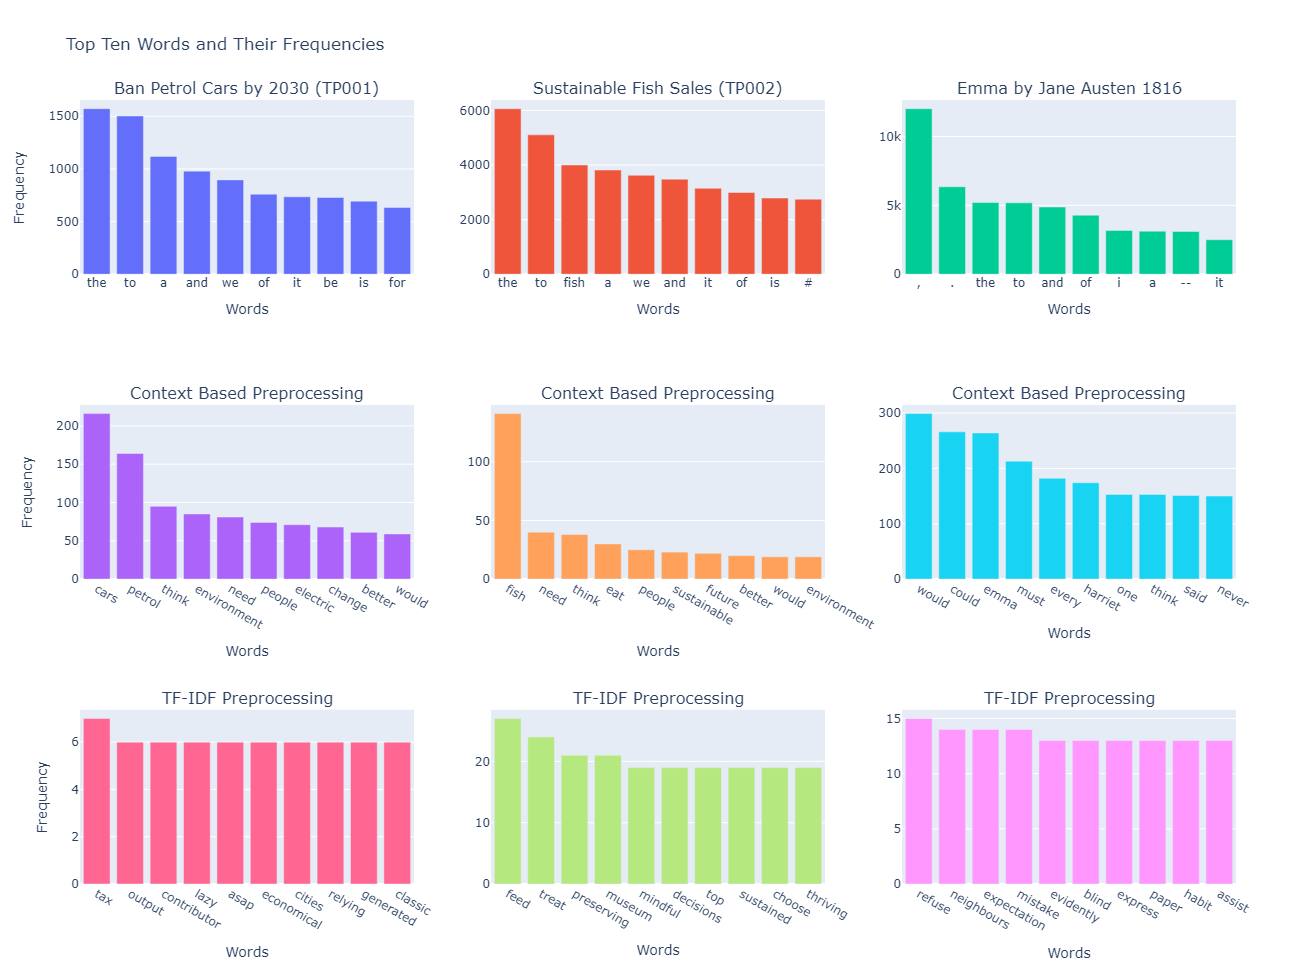

From the raw frequency graphs at the top, we see that common stopwords like "the", "to", "and", "of" dominate in all texts. This is typical in unprocessed texts, as such function words are necessary for grammatical structure but carry little unique meaning.

After context-based preprocessing, which includes stopword removal and lowercasing, the graphs show a drastic change. The most frequent words now appear to be more topical and content-specific, such as "cars", "electric", and "environment" for TP001, and "fish", "sustainable", and "future" for TP002. This suggests that the context-based preprocessing has effectively removed the noise of common words, bringing content-specific terms to the forefront.

For Emma by Jane Austen, even after context-based preprocessing, some common words like "would" and "could" remain frequent, possibly indicating their importance in the narrative style of the era, the author or in this specific text.

The TF-IDF preprocessing further refines the word frequencies by considering the importance of words across multiple documents. The words that remain after TF-IDF preprocessing have lower frequencies than the unprocessed and context-processed lists, but they're weighted to be more significant within the context of their respective documents. Words like "tax", "output", and "combustion" for TP001 and "feed", "treat", "thriving" for TP002 suggest that TF-IDF has brought out terms which are not just common in the individual text but also distinct compared to others in the corpus. This implies that these words are particularly descriptive or relevant to the subject matter of the text.

For Emma, we see words like "refuse", "express", and "neighbors" which point to key themes and elements of the plot unique within the context of its corpus.

####**Effects of Processing Approaches on The Top Ten Words:**
**Context-Based Preprocessing:**
- Leaves words that are more relevant to the specific context of each text, allowing for a clearer view of the main themes and subjects.
- Can still include common words that are not stopwords but occur frequently across different texts and may not be contextually unique.

**TF-IDF Preprocessing:**
- Goes a step further by scoring words based on their distinctiveness across the corpus.
- Brings forward the words that are potentially the most defining for each text, even if they aren't the most frequent.
- Can reveal the underlying themes and topics of a text that might be overlooked with simple frequency counts.

####**Trends and Observations:**
- **Stopword Prevalence in Raw Text:** Initially, stopwords dominate the list of frequent words and the effects of processing become clear as words that show the content of the text are revealed.
- **Content Relevance in Preprocessed Text:** After context-based preprocessing, the words that remain are more content-specific, suggesting a significant removal of common words that don't contribute to the unique meaning of the text.
- **Uniqueness Highlighted by TF-IDF:** TF-IDF seems to show a much lower frequency range, suggesting that these words, while critical, appear less frequently than common stopwords. This also implies that TF-IDF is effective at identifying words that are important within a specific document but less common in the language as a whole.

In [ ]:
#@title ##Graph Generation {display-mode: "form"}
# Extracting top ten words and their frequencies for plotting
tp001_top_ten_words, tp001_frequencies = zip(*tp001_metrics['top_ten_words'])
tp002_top_ten_words, tp002_frequencies = zip(*tp002_metrics['top_ten_words'])
emma_top_ten_words, emma_frequencies = zip(*emma_metrics['top_ten_words'])

preprocessed_tp001_top_ten, preprocessed_tp001_freq = zip(*preprocessed_tp001_metrics['top_ten_words'])
preprocessed_tp002_top_ten, preprocessed_tp002_freq = zip(*preprocessed_tp002_metrics['top_ten_words'])
preprocessed_emma_top_ten, preprocessed_emma_freq = zip(*preprocessed_emma_metrics['top_ten_words'])

tf_idf_tp001_top_ten, tf_idf_tp001_freq = zip(*tf_idf_tp001_metrics['top_ten_words'])
tf_idf_tp002_top_ten, tf_idf_tp002_freq = zip(*tf_idf_tp002_metrics['top_ten_words'])
tf_idf_emma_top_ten, tf_idf_emma_freq = zip(*tf_idf_emma_metrics['top_ten_words'])

# Create a subplot figure with 3 rows and 3 columns (transposed)
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=(
        'Ban Petrol Cars by 2030 (TP001)',
        'Sustainable Fish Sales (TP002)',
        'Emma by Jane Austen 1816',
        'Context Based Preprocessing',
        'Context Based Preprocessing',
        'Context Based Preprocessing',
        'TF-IDF Preprocessing',
        'TF-IDF Preprocessing',
        'TF-IDF Preprocessing')
)

# Original TP001
fig.add_trace(
    go.Bar(x=tp001_top_ten_words, y=tp001_frequencies),
    row=1, col=1
)

# Original TP002
fig.add_trace(
    go.Bar(x=tp002_top_ten_words, y=tp002_frequencies),
    row=1, col=2
)

# Original Emma
fig.add_trace(
    go.Bar(x=emma_top_ten_words, y=emma_frequencies),
    row=1, col=3
)

# Preprocessed TP001
fig.add_trace(
    go.Bar(x=preprocessed_tp001_top_ten, y=preprocessed_tp001_freq),
    row=2, col=1
)

# Preprocessed TP002
fig.add_trace(
    go.Bar(x=preprocessed_tp002_top_ten, y=preprocessed_tp002_freq),
    row=2, col=2
)

# Preprocessed Emma
fig.add_trace(
    go.Bar(x=preprocessed_emma_top_ten, y=preprocessed_emma_freq),
    row=2, col=3
)

# TF-IDF TP001
fig.add_trace(
    go.Bar(x=tf_idf_tp001_top_ten, y=tf_idf_tp001_freq),
    row=3, col=1
)

# TF-IDF TP002
fig.add_trace(
    go.Bar(x=tf_idf_tp002_top_ten, y=tf_idf_tp002_freq),
    row=3, col=2
)

# TF-IDF Emma
fig.add_trace(
    go.Bar(x=tf_idf_emma_top_ten, y=tf_idf_emma_freq),
    row=3, col=3
)

# Update layout
fig.update_layout(
    title_text='Top Ten Words and Their Frequencies',
    showlegend=False,
    height=970
)

# Customize axis labels
for row in range(1, 4):
    for col in range(1, 4):
        fig.update_xaxes(title_text='Words', row=row, col=col)

fig.update_yaxes(title_text='Frequency', row=1, col=1)
fig.update_yaxes(title_text='Frequency', row=2, col=1)
fig.update_yaxes(title_text='Frequency', row=3, col=1)

# Show the figure
fig.show()

## **Comparative Analysis of Overall Lexical Diversity in Processed and Unprocessed Versions of Emma**

The results of the analysis show the overall lexical diversity of Jane Austen's "Emma" in both its processed and unprocessed forms as the batch size (number of sentences per batch) increases. It demonstrates how lexical diversity decreases as the size of the text increases.

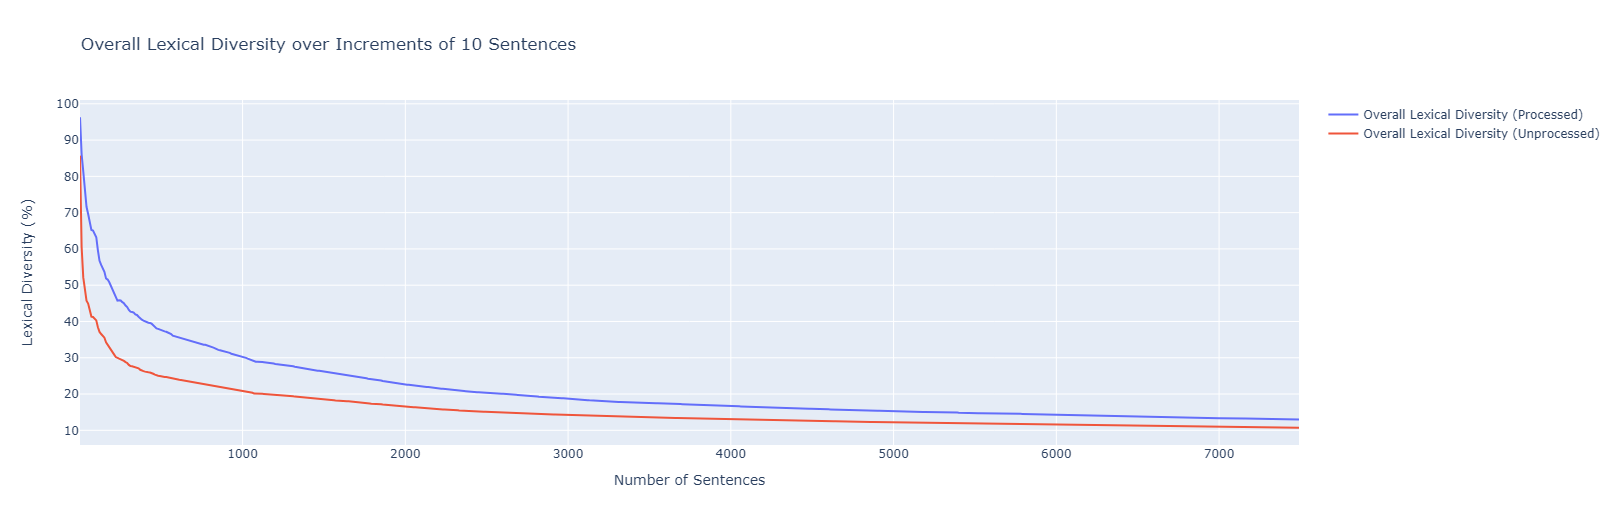

**Processed Overall Lexical Diversity (Blue):** As the batch size increases, we observe a gradual decrease in lexical diversity for the processed version. This trend indicates that when analyzing larger portions of the text together, the processed version becomes less lexically diverse. This is attributed to the removal of high-frequency and stop words during processing, which results in a more focused vocabulary.

**Unprocessed Overall Lexical Diversity (Red):** The red line represents the lexical diversity of the original, unprocessed text. In this case, as the batch size increases, we see a sharp decrease in lexical diversity of the unprocessed text. This decrease suggests that even in the unprocessed text, certain words become more prominent and repetitive when analyzing larger sections of the text.

In summary, overall lexical diversity highlights how text processing affects the diversity of words in a text, particularly as the of a text scale increases. While both processed and unprocessed texts exhibit a decrease in lexical diversity with larger batch sizes, the unprocessed version tends to show a more pronounced decrease due to the inherent diversity in this large text.

In [ ]:
#@title ##Graph Generation {display-mode: "form"}

increment = 10  # n sentences per increment
emma_num_sentences = emma_metrics['num_sentences']
batch_sizes = list(range(1, emma_num_sentences, increment))  # Incrementally increase batch size

ld_unprocessed = []
ld_processed = []

sentences = sent_tokenize(emma_text)
cleaned_sentences = [clean_text(sentence, stop_words) for sentence in sentences]

# Calculate lexical diversities
for batch_size in batch_sizes:
    unprocessed_batch = ' '.join(sentences[:batch_size])
    processed_batch = ' '.join(cleaned_sentences[:batch_size])

    unprocessed_words = unprocessed_batch.lower().split()
    processed_words = processed_batch.lower().split()

    unprocessed_diversity = lexical_diversity(unprocessed_words)
    processed_diversity = lexical_diversity(processed_words)

    ld_unprocessed.append(unprocessed_diversity)
    ld_processed.append(processed_diversity)

# Prepare batch size labels with sentence count
batch_size_labels = [batch_size for batch_size in batch_sizes]

# Convert lexical diversity to percentages
processed_lex_div = [ld * 100 for ld in ld_processed]
unprocessed_lex_div = [ld * 100 for ld in ld_unprocessed]

# Create traces
trace1 = go.Scatter(
    x=batch_size_labels,
    y=processed_lex_div,
    mode='lines',
    name='Overall Lexical Diversity (Processed)',
)
trace2 = go.Scatter(
    x=batch_size_labels,
    y=unprocessed_lex_div,
    mode='lines',
    name='Overall Lexical Diversity (Unprocessed)',
)

# Layout
layout = go.Layout(
    title='Overall Lexical Diversity over Increments of ' + str(increment) + ' Sentences',
    xaxis=dict(title='Number of Sentences'),
    yaxis=dict(title='Lexical Diversity (%)'),
)

# Figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()